# GROUP 19
Dataset: IMDB Spoiler Dataset

Motivation:
User reviews are one of the first places people look when deciding whether to watch a movie or TV show but these reviews often contain spoilers that unintentionally ruin our viewing experience. Those spoilers may reveal key plot twists or endings, removing the suspense and emotional impact that make storytelling enjoyable. This is a significant problem for audiences who risk having our experiences diminished, and for review platforms which risk lower user trust and engagement. By building systems to automatically detect and filter spoilers, platforms can protect users from unwanted revelations while still allowing them to benefit from genuine reviews. The outcome would benefit casual viewers, streaming platforms and content creators alike, ensuring reviews remain helpful without spoiling the narrative.

## Load and Clean Dataset

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
movie_details = []
movie_reviews = []

def load_dataset(filepath: str):
    dataset = []
    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if line:
                data = json.loads(line)
                dataset.append(data)
    return dataset

def duration_to_minutes(duration):
    hour_match = re.search(r'(\d+)\s*h', duration)
    min_match = re.search(r'(\d+)\s*min', duration)

    hours = 0
    minutes = 0

    if hour_match:
        hours = int(hour_match.group(1))
    if min_match:
        minutes = int(min_match.group(1))
        
    return (hours * 60) + minutes

In [4]:
from ast import literal_eval
import ast
movie_details = pd.DataFrame(load_dataset("E:/Documents/NUS/Academic/Jupyter Notebook Project/CS3244/data/IMDB_movie_details.json"))

movie_details['duration'] = movie_details['duration'].apply(duration_to_minutes)
movie_details['release_date'] = pd.to_datetime(movie_details['release_date'], errors='coerce')
movie_details['rating'] = pd.to_numeric(movie_details['rating'], errors='coerce')
movie_details['plot_synopsis'].replace("", np.nan, inplace=True)

movie_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",117,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",105,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",97,"[Comedy, Romance]",6.7,2002-04-11,NaN
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",126,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,103,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [5]:
movie_reviews = pd.DataFrame(load_dataset("E:/Documents/NUS/Academic/Jupyter Notebook Project/CS3244/data/IMDB_reviews.json"))

movie_reviews['review_date'] = pd.to_datetime(movie_reviews['review_date'], errors='coerce')
movie_reviews['is_spoiler'] = movie_reviews['is_spoiler'].astype(bool)
movie_reviews['rating'] = pd.to_numeric(movie_reviews['rating'], errors='coerce')
movie_reviews['review_id'] = np.arange(len(movie_reviews))

movie_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_id
0,2006-02-10,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,0
1,2000-09-06,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,1
2,2001-08-03,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film,2
3,2002-09-01,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,3
4,2004-05-20,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",4


In [6]:
train_data, test_data = train_test_split(
    movie_reviews,
    test_size=0.2,
    stratify=movie_reviews['is_spoiler'], 
    random_state=42
)

In [7]:
train_data.shape

(459130, 8)

In [8]:
test_data.shape

(114783, 8)

## Exploratory Data Analysis

### Review's length Impact
The plot suggest that longer reviews are more spoiler-prone. Once reviews get past the very short range (0-999 words), spoiler likelihood sits above the overall baseline and generally increases with length. Short reviews tends to be non-spoiler because they’re brief and the dataset is skewed that way (imbalance). Long reviews show a strong spoiler tendency which is likely because they include plot summaries. However, but a few of those bins with long reviews has small number of reviews , so treat it with caution. 

Overall, we think that review length should be included as a supporting feature as it carries useful signal, especially the general “longer → riskier” trend.

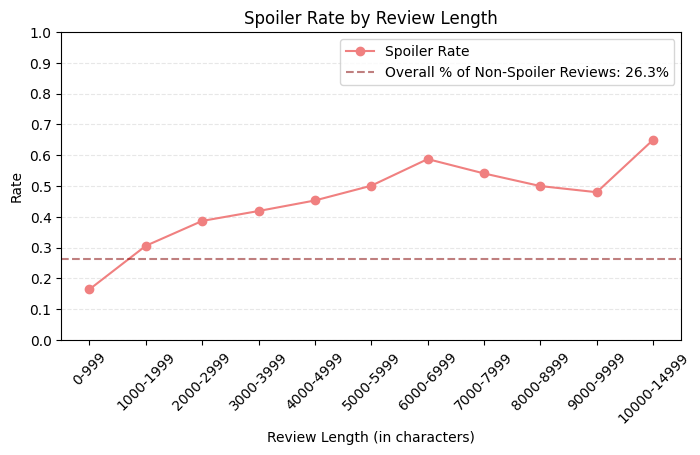

In [9]:
review_len_df = train_data[['review_text','is_spoiler']].copy()
review_len_df['review_length'] = train_data['review_text'].apply(lambda x: len(x))

review_len_df.sort_values('review_length',ascending=False).head(50)

bin_review_lengths = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000]
binned_review_lengths = pd.cut(
    review_len_df['review_length'],
    bins=bin_review_lengths,
    labels=[f"{bin_review_lengths[i]}-{bin_review_lengths[i+1]-1}" for i in range(len(bin_review_lengths)-1)],
    include_lowest=True,
    right=True
)
review_len_df["bin_review_length"] = binned_review_lengths

review_len_df = review_len_df.groupby('bin_review_length')['is_spoiler'].value_counts().unstack()

column_name = ['non_spoiler_rate', 'spoiler_rate']
review_len_df.columns = column_name

review_len_df['n_reviews'] = review_len_df['non_spoiler_rate'] + review_len_df['spoiler_rate']

review_len_df["non_spoiler_rate"] = review_len_df['non_spoiler_rate']/review_len_df['n_reviews']
review_len_df["spoiler_rate"] = review_len_df['spoiler_rate']/review_len_df['n_reviews']

# plot
fig, ax = plt.subplots(figsize=(8, 4))
line = ax.plot(review_len_df.index, review_len_df['spoiler_rate'], marker='o', color='lightcoral', label='Spoiler Rate')

ax.axhline(y = 0.263, xmin=0, xmax=20000, color='maroon', linestyle='dashed', alpha = 0.5, label='Overall % of Non-Spoiler Reviews: 26.3%')

ax.set_title("Spoiler Rate by Review Length")
ax.set_xlabel("Review Length (in characters)")
ax.set_ylabel("Rate")
ax.set_xticklabels(review_len_df.index, rotation=45)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend()
plt.show()  

In [10]:
review_len_df

,non_spoiler_rate,spoiler_rate,n_reviews
bin_review_length,,,
0-999,0.835271,0.164729,216294
1000-1999,0.693977,0.306023,143950
2000-2999,0.613195,0.386805,52021
3000-3999,0.581005,0.418995,24375
4000-4999,0.546793,0.453207,12566
5000-5999,0.498861,0.501139,9215
6000-6999,0.412389,0.587611,565
7000-7999,0.459016,0.540984,61
8000-8999,0.500000,0.500000,38


## SMOTE (to handle data imbalanced)

### SMOTE per bin based on the review length

Seeing that there is imbalanced data for each bin of review length, I am trying to do SMOTE per bin based on the review length 

text -> TF-IDF (sparse) -> SVD (dense) -> StandardScaler (dense)
Converts raw text into a dense, scaled embedding suitable for SMOTE.

In [30]:
# Compute review length
movie_reviews["review_length"] = movie_reviews[TEXT_COL].str.len()

# Bin review length into categories
movie_reviews["bin_review_length"] = pd.cut(
    movie_reviews["review_length"],
    bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000],
    labels=[
        "0-999", "1000-1999", "2000-2999", "3000-3999", "4000-4999",
        "5000-5999", "6000-6999", "7000-7999", "8000-8999", "9000-9999", "10000-14999"
    ],
    include_lowest=True
)

In [31]:
train_data, test_data = train_test_split(
    movie_reviews,
    test_size=0.2,
    stratify=movie_reviews['is_spoiler'], 
    random_state=42
)

In [32]:
train_data["bin_review_length"].value_counts().sort_index()


bin_review_length
0-999          216294
1000-1999      143950
2000-2999       52021
3000-3999       24375
4000-4999       12566
5000-5999        9215
6000-6999         565
7000-7999          61
8000-8999          38
9000-9999          25
10000-14999        20
Name: count, dtype: int64

In [33]:
pd.crosstab(train_data["bin_review_length"], train_data["is_spoiler"], normalize='index')


is_spoiler,False,True
bin_review_length,,
0-999,0.835271,0.164729
1000-1999,0.693977,0.306023
2000-2999,0.613195,0.386805
3000-3999,0.581005,0.418995
4000-4999,0.546793,0.453207
5000-5999,0.498861,0.501139
6000-6999,0.412389,0.587611
7000-7999,0.459016,0.540984
8000-8999,0.500000,0.500000


In [34]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

def smote_per_bin(X, y, bins, sampling_strategy="auto", k_neighbors=3, random_state=None):
    """
    Applies SMOTE within each review-length bin separately.
    Returns concatenated resampled X and y.
    """
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled_list, y_resampled_list = [], []

    unique_bins = np.unique(bins)
    print(f"Applying SMOTE per bin: {unique_bins}")

    for b in unique_bins:
        mask = bins == b
        X_b, y_b = X[mask], y[mask]
        
        # Skip bins that don't have both classes
        if len(np.unique(y_b)) < 2:
            print(f"Skipping bin {b}: only one class present.")
            X_resampled_list.append(X_b)
            y_resampled_list.append(y_b)
            continue
        
        try:
            X_res, y_res = smote.fit_resample(X_b, y_b)
            X_resampled_list.append(X_res)
            y_resampled_list.append(y_res)
            print(f"✔ Bin {b}: from {len(y_b)} to {len(y_res)} samples")
        except ValueError as e:
            print(f"⚠ Skipping bin {b} due to SMOTE error: {e}")
            X_resampled_list.append(X_b)
            y_resampled_list.append(y_b)

    X_all = np.vstack(X_resampled_list)
    y_all = np.concatenate(y_resampled_list)
    return X_all, y_all


In [48]:
# Separate features and labels
X_train_text = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]

# TF-IDF + SVD (dense representation)
X_train_dense = pre_dense.fit_transform(X_train_text)

# Apply SMOTE *within each bin* (using the bin info from train_data)
X_train_bal, y_train_bal = smote_per_bin(
    X_train_dense,
    y_train.values,
    train_data["bin_review_length"].values,
    sampling_strategy="auto",
    k_neighbors=3,
    random_state=RANDOM_SEED
)

# Fit your grid search on the balanced data
grid.fit(X_train_bal, y_train_bal)


Applying SMOTE per bin: ['0-999' '1000-1999' '10000-14999' '2000-2999' '3000-3999' '4000-4999'
 '5000-5999' '6000-6999' '7000-7999' '8000-8999' '9000-9999']
✔ Bin 0-999: from 216294 to 361328 samples
✔ Bin 1000-1999: from 143950 to 199796 samples
✔ Bin 10000-14999: from 20 to 26 samples
✔ Bin 2000-2999: from 52021 to 63798 samples
✔ Bin 3000-3999: from 24375 to 28324 samples
✔ Bin 4000-4999: from 12566 to 13742 samples
✔ Bin 5000-5999: from 9215 to 9236 samples
✔ Bin 6000-6999: from 565 to 664 samples
✔ Bin 7000-7999: from 61 to 66 samples
✔ Bin 8000-8999: from 38 to 38 samples
✔ Bin 9000-9999: from 25 to 26 samples


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'sm__k_neighbors': [3, 5],
                         'sm__sampling_strategy': [0.3, 0.5, 0.8, 'auto']},
             scoring='average_precision')

#### Tune SMOTE (grid search)

For each of the review length bin, I am trying to find the best hyperparameter of it

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, ParameterGrid
from sklearn.base import clone
from sklearn.metrics import f1_score
import numpy as np

def _allowed_k_values(y, k_values):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2:
        return []
    minority_count = counts.min()
    return [k for k in k_values if isinstance(k, int) and 1 < k < minority_count]

def _choose_cv(y, desired_cv=3):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2:
        return None
    m = counts.min()
    if m >= desired_cv: return desired_cv
    if m >= 2: return 2
    return None  # too small → use holdout

def _manual_holdout_search(X, y, clf, param_grid, scoring='f1', random_state=None, test_size=0.4):
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    best_score, best_params = -np.inf, None
    for params in ParameterGrid(param_grid):
        smote_kwargs = {k.replace('smote__',''): v for k, v in params.items() if k.startswith('smote__')}
        if 'k_neighbors' in smote_kwargs:
            if not _allowed_k_values(y_tr, [smote_kwargs['k_neighbors']]):
                continue
        pipe = Pipeline([
            ('smote', SMOTE(random_state=random_state, **smote_kwargs)),
            ('clf', clone(clf))
        ])
        try:
            pipe.fit(X_tr, y_tr)
            y_hat = pipe.predict(X_va)
            score = f1_score(y_va, y_hat, average='binary' if len(np.unique(y_va))==2 else 'macro')
        except Exception:
            continue
        if score > best_score:
            best_score, best_params = score, params
    return best_params, best_score

def smote_per_bin_tuned(
    X, y, bins, clf,
    param_grid=None,
    scoring='f1',
    cv=3,
    random_state=None,
    verbose=True
):
    """
    Tunes SMOTE inside each bin with a classifier, then resamples the full bin using best SMOTE.
    Returns concatenated resampled X, y and a per-bin report.
    """
    if param_grid is None:
        param_grid = {
            'smote__k_neighbors': [2, 3, 5],
            'smote__sampling_strategy': ['auto', 0.75, 1.0]
        }

    # ensure numpy arrays
    X_arr = np.asarray(X) if not hasattr(X, 'iloc') else X.values
    y_arr = np.asarray(y)
    b_arr = np.asarray(bins)

    X_out, y_out = [], []
    report = {}

    for b in np.unique(b_arr):
        mask = (b_arr == b)
        X_b, y_b = X_arr[mask], y_arr[mask]
        classes, counts = np.unique(y_b, return_counts=True)

        if len(classes) < 2:
            if verbose: print(f"[bin={b}] Only one class — skipping SMOTE.")
            X_out.append(X_b); y_out.append(y_b)
            report[b] = {'best_params': None, 'best_score': None, 'cv_used': None, 'minority_count': int(counts.min())}
            continue

        # filter k_neighbors that are feasible given minority size
        grid = dict(param_grid)
        if 'smote__k_neighbors' in grid:
            feasible_ks = _allowed_k_values(y_b, grid['smote__k_neighbors'])
            if not feasible_ks:
                # last-resort k based on size
                minority_count = counts.min()
                feasible_ks = [2] if minority_count > 2 else [max(2, minority_count - 1)]
            grid['smote__k_neighbors'] = feasible_ks

        # choose CV or fallback to holdout
        cv_used = _choose_cv(y_b, desired_cv=cv)
        if cv_used is None:
            best_params, best_score = _manual_holdout_search(X_b, y_b, clf, grid, scoring=scoring, random_state=random_state)
        else:
            pipe = Pipeline([('smote', SMOTE(random_state=random_state)), ('clf', clone(clf))])
            kfold = StratifiedKFold(n_splits=cv_used, shuffle=True, random_state=random_state)
            gs = GridSearchCV(pipe, grid, scoring=scoring, cv=kfold, n_jobs=1, error_score='raise')
            try:
                gs.fit(X_b, y_b)
                best_params, best_score = gs.best_params_, gs.best_score_
            except Exception as e:
                if verbose: print(f"[bin={b}] CV failed ({e}). Using holdout.")
                best_params, best_score = _manual_holdout_search(X_b, y_b, clf, grid, scoring=scoring, random_state=random_state)

        report[b] = {
            'best_params': best_params,
            'best_score': best_score,
            'cv_used': cv_used,
        }

        # resample the FULL bin using the chosen SMOTE params
        if best_params is None:
            # fallback: try a safe k
            ks = _allowed_k_values(y_b, [5,3,2])
            smote_kwargs = {'k_neighbors': (ks[0] if ks else 2), 'random_state': random_state}
        else:
            smote_kwargs = {k.replace('smote__',''): v for k, v in best_params.items() if k.startswith('smote__')}
            smote_kwargs['random_state'] = random_state

        try:
            X_res_b, y_res_b = SMOTE(**smote_kwargs).fit_resample(X_b, y_b)
            X_out.append(X_res_b); y_out.append(y_res_b)
        except Exception as e:
            if verbose: print(f"[bin={b}] Final resample failed ({e}). Keeping original bin.")
            X_out.append(X_b); y_out.append(y_b)

    return np.vstack(X_out), np.concatenate(y_out), report


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from collections import Counter
import pandas as pd
import numpy as np

X_train_text = train_data[TEXT_COL].astype(str)
y_train = train_data[TARGET_COL].values

X_test_text  = test_data[TEXT_COL].astype(str)
y_test       = test_data[TARGET_COL].values

X_train_dense = pre_dense.fit_transform(X_train_text)
X_test_dense  = pre_dense.transform(X_test_text)

bins_train = train_data["bin_review_length"].astype(object).fillna("unbinned").values

clf_for_tuning = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_SEED)

smote_param_grid = {
    "smote__k_neighbors": [2, 3, 5, 7],
    "smote__sampling_strategy": ["auto", 0.5, 0.75, 1.0],
}

X_train_bal, y_train_bal, per_bin_report = smote_per_bin_tuned(
    X=X_train_dense,
    y=y_train,
    bins=bins_train,
    clf=clf_for_tuning,
    param_grid=smote_param_grid,
    scoring="f1",        
    cv=3,               
    random_state=RANDOM_SEED,
    verbose=False
)

print("Class balance (original):", Counter(y_train))
print("Class balance (balanced):", Counter(y_train_bal))

per_bin_df = pd.DataFrame.from_dict(per_bin_report, orient="index").reset_index()
per_bin_df.columns = ["bin", "best_params", "best_score", "cv_used"]
try:
    display(per_bin_df)
except NameError:
    print(per_bin_df)

grid.fit(X_train_bal, y_train_bal)

print("Grid best score (CV on balanced data):", getattr(grid, "best_score_", None))
print("Grid best params:", getattr(grid, "best_params_", None))

y_pred = grid.predict(X_test_dense)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred))

if hasattr(grid, "predict_proba"):
    try:
        y_proba = grid.predict_proba(X_test_dense)[:, 1]
        print("ROC-AUC (test):", round(roc_auc_score(y_test, y_proba), 4))
    except Exception:
        pass


Class balance (original): Counter({False: 338391, True: 120739})
Class balance (balanced): Counter({False: 338439, True: 293356})


,bin,best_params,best_score,cv_used
0,0-999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.355324,3
1,1000-1999,"{'smote__k_neighbors': 7, 'smote__sampling_str...",0.497845,3
2,10000-14999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.909091,3
3,2000-2999,"{'smote__k_neighbors': 5, 'smote__sampling_str...",0.573650,3
4,3000-3999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.590463,3
5,4000-4999,"{'smote__k_neighbors': 3, 'smote__sampling_str...",0.631259,3
6,5000-5999,"{'smote__k_neighbors': 5, 'smote__sampling_str...",0.650750,3
7,6000-6999,"{'smote__k_neighbors': 7, 'smote__sampling_str...",0.704981,3
8,7000-7999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.645161,3
9,8000-8999,"{'smote__k_neighbors': 2, 'smote__sampling_str...",0.153846,3


Grid best score (CV on balanced data): 0.6700792083194974
Grid best params: {'sm__k_neighbors': 5, 'sm__sampling_strategy': 'auto'}

Classification report (test):
              precision    recall  f1-score   support

       False       0.83      0.67      0.74     84598
        True       0.39      0.61      0.48     30185

    accuracy                           0.65    114783
   macro avg       0.61      0.64      0.61    114783
weighted avg       0.71      0.65      0.67    114783

ROC-AUC (test): 0.6862


## Aurelia Week 11 

GOAL:
- Performed SMOTE resampling to balance spoiler vs. non-spoiler classes for each review length bin

- Use Logistic regression to calculate the recall 

- Implement TF-IDF + undersampling

- Use logistic regression to calculate the recall


In [15]:
# Define Review Length Bins

bin_review_lengths = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000]
bin_labels = [f"{bin_review_lengths[i]}-{bin_review_lengths[i+1]-1}" for i in range(len(bin_review_lengths)-1)]

train_data['review_text'] = train_data['review_text'].fillna('')
train_data['review_summary'] = train_data['review_summary'].fillna('')
train_data['review_length'] = train_data['review_text'].apply(len)
train_data["bin_review_length"] = pd.cut(
    train_data['review_length'], 
    bins=bin_review_lengths, 
    labels=bin_labels, 
    include_lowest=True
)

In [16]:
# Define TF-IDF Vectorizers

tfidf_review = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.95,
    lowercase=True,
    strip_accents='unicode'
)

tfidf_summary = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3,
    max_df=0.9,
    lowercase=True,
    strip_accents='unicode'
)

### SMOTE PER BIN WITHOUT ADDITIONAL FEATURE ENGGINERING

✅ Logistic Regression Recall: 0.4327

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from imblearn.over_sampling import SMOTE
import pickle
from tqdm import tqdm

# Initialize Result Storage
balanced_bins = {}
print("Balancing each review length group using SMOTE...\n")

for bin_label in tqdm(bin_labels):
    bin_df = train_data[train_data["bin_review_length"] == bin_label]
    if bin_df.empty:
        continue

    y = bin_df['is_spoiler']
    
    if len(bin_df) < 100 or len(np.unique(y)) < 2:
        print(f"Skipping bin {bin_label}: insufficient samples for SMOTE.")
        continue

    # TF-IDF vectorization
    X_review_tfidf = tfidf_review.fit_transform(bin_df['review_text'])
    X_summary_tfidf = tfidf_summary.fit_transform(bin_df['review_summary'])
    X_combined = hstack([X_review_tfidf, X_summary_tfidf])

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_combined, y)

    # Store results per bin
    balanced_bins[bin_label] = {
        "X_resampled": X_resampled,
        "y_resampled": y_resampled,
        "tfidf_review": tfidf_review,
        "tfidf_summary": tfidf_summary
    }

print("\n✅ SMOTE balancing complete for all bins!")



Balancing each review length group using SMOTE...



100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [17:22<00:00, 94.80s/it]

Skipping bin 7000-7999: insufficient samples for SMOTE.
Skipping bin 8000-8999: insufficient samples for SMOTE.
Skipping bin 9000-9999: insufficient samples for SMOTE.
Skipping bin 10000-14999: insufficient samples for SMOTE.

✅ SMOTE balancing complete for all bins!


In [19]:
# Save resampled data for later use 
with open("balanced_bins_smote.pkl", "wb") as f:
    pickle.dump(balanced_bins, f)

print("💾 Balanced TF-IDF + SMOTE data saved to 'balanced_bins_smote.pkl'")

💾 Balanced TF-IDF + SMOTE data saved to 'balanced_bins_smote.pkl'


In [21]:
# Combine all bins from balanced_bins
balanced_dataframes = []

for bin_label, data_dict in balanced_bins.items():
    # Extract y_resampled as a series
    y_res = pd.Series(data_dict['y_resampled'], name='is_spoiler')
    n_samples = len(y_res)

    # Use original review_text/review_summary repeated (approximate)
    review_text_res = np.random.choice(train_data[train_data['bin_review_length']==bin_label]['review_text'], size=n_samples, replace=True)
    review_summary_res = np.random.choice(train_data[train_data['bin_review_length']==bin_label]['review_summary'], size=n_samples, replace=True)

    df_bin = pd.DataFrame({
        'review_text': review_text_res,
        'review_summary': review_summary_res,
        'is_spoiler': y_res,
        'bin_review_length': bin_label
    })

    balanced_dataframes.append(df_bin)

# Concatenate all bins
balanced_train_data = pd.concat(balanced_dataframes, ignore_index=True)
print(f"Final balanced dataset shape: {balanced_train_data.shape}")
print(balanced_train_data['is_spoiler'].value_counts())

# Save to CSV
balanced_train_data.to_csv('balanced_train_data_by_length.csv', index=False)
print("✅ Balanced dataset saved as 'balanced_train_data_by_length.csv'")


Final balanced dataset shape: (676888, 4)
is_spoiler
False    338444
True     338444
Name: count, dtype: int64
✅ Balanced dataset saved as 'balanced_train_data_by_length.csv'


#### Try different logistic regression model 

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score

# 1. Load the balanced dataset
balanced_train_data = pd.read_csv('balanced_train_data_by_length.csv')
print(f"Dataset shape: {balanced_train_data.shape}")
print(balanced_train_data['is_spoiler'].value_counts())

# 2. Split into features and target
balanced_train_data['review_text'] = balanced_train_data['review_text'].fillna('')
balanced_train_data['review_summary'] = balanced_train_data['review_summary'].fillna('')
X_text = balanced_train_data['review_text'] + " " + balanced_train_data['review_summary']
y = balanced_train_data['is_spoiler']

# 3. Train/test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)


Dataset shape: (676888, 4)
is_spoiler
False    338444
True     338444
Name: count, dtype: int64


In [29]:
# 4. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print(f"TF-IDF train shape: {X_train_tfidf.shape}, test shape: {X_test_tfidf.shape}")

TF-IDF train shape: (541510, 5000), test shape: (135378, 5000)


In [42]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

# --- Load the balanced dataset ---
balanced_train_data = pd.read_csv("balanced_train_data_by_length.csv")

# --- Prepare text and label ---
balanced_train_data['review_text'] = balanced_train_data['review_text'].fillna('')
balanced_train_data['review_summary'] = balanced_train_data['review_summary'].fillna('')

# Combine text and summary for richer context
X_text = balanced_train_data['review_text'] + " " + balanced_train_data['review_summary']
y = balanced_train_data['is_spoiler']

# --- Split train/test ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# --- TF-IDF vectorization ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# --- Train Logistic Regression ---
logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logreg.fit(X_train_tfidf, y_train)

# --- Evaluate Recall ---
y_pred = logreg.predict(X_test_tfidf)
recall = recall_score(y_test, y_pred)

print(f"✅ Logistic Regression Recall: {recall:.4f}")


✅ Logistic Regression Recall: 0.4327


### SMOTE WITH ADDITIONAL FEATURE ENGGINERING

✅ Logistic Regression Recall: 0.5007

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pickle

# Fill missing values and prepare review length bins 
train_data['review_text'] = train_data['review_text'].fillna('')
train_data['review_summary'] = train_data['review_summary'].fillna('')
train_data['review_length'] = train_data['review_text'].apply(len)

bin_review_lengths = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,15000]
bin_labels = [f"{bin_review_lengths[i]}-{bin_review_lengths[i+1]-1}" for i in range(len(bin_review_lengths)-1)]
train_data['bin_review_length'] = pd.cut(
    train_data['review_length'], bins=bin_review_lengths, labels=bin_labels, include_lowest=True
)

# Create additional numerical features
train_data['review_text_length'] = train_data['review_text'].str.len()
train_data['review_summary_length'] = train_data['review_summary'].str.len()
train_data['word_count'] = train_data['review_text'].str.split().str.len()

# User-based features
user_stats = train_data.groupby('user_id')['is_spoiler'].agg(['sum','count']).reset_index()
user_stats.columns = ['user_id','user_spoiler_count','user_total_reviews']
user_stats['user_spoiler_rate'] = user_stats['user_spoiler_count'] / user_stats['user_total_reviews']
train_data = train_data.merge(user_stats, on='user_id', how='left')

# Movie-based features
movie_stats = train_data.groupby('movie_id')['is_spoiler'].agg(['sum','count']).reset_index()
movie_stats.columns = ['movie_id','movie_spoiler_count','movie_total_reviews']
movie_stats['movie_spoiler_rate'] = movie_stats['movie_spoiler_count'] / movie_stats['movie_total_reviews']
train_data = train_data.merge(movie_stats, on='movie_id', how='left')

# Rating & date features
train_data['rating'] = pd.to_numeric(train_data['rating'], errors='coerce').fillna(train_data['rating'].median())
train_data['review_date'] = pd.to_datetime(train_data['review_date'], errors='coerce')
train_data['review_year'] = train_data['review_date'].dt.year.fillna(0).astype(int)
train_data['review_month'] = train_data['review_date'].dt.month.fillna(0).astype(int)
train_data['review_day_of_week'] = train_data['review_date'].dt.dayofweek.fillna(0).astype(int)


In [32]:
# Define TF-IDF vectorizers
bin_smote_tfidf_review = TfidfVectorizer(
    max_features=5000, ngram_range=(1,2),
    stop_words='english', min_df=5, max_df=0.95,
    lowercase=True, strip_accents='unicode'
)
bin_smote_tfidf_summary = TfidfVectorizer(
    max_features=2000, ngram_range=(1,2),
    stop_words='english', min_df=3, max_df=0.9,
    lowercase=True, strip_accents='unicode'
)

bin_smote_numerical_features = [
    'review_text_length','review_summary_length','word_count',
    'user_spoiler_rate','movie_spoiler_rate','rating',
    'review_year','review_month','review_day_of_week'
]


In [33]:
bin_smote_balanced_dfs = []
bin_smote_scaler = StandardScaler()

print("⚙️ Balancing each review length group using SMOTE with text + numerical features...\n")

for bin_label in tqdm(bin_labels):
    bin_df = train_data[train_data['bin_review_length'] == bin_label]
    if bin_df.empty:
        continue
    
    y = bin_df['is_spoiler']
    if len(bin_df) < 100 or len(np.unique(y)) < 2:
        print(f"Skipping bin {bin_label}: insufficient samples for SMOTE.")
        continue

    # --- TF-IDF vectorization ---
    X_review_tfidf = bin_smote_tfidf_review.fit_transform(bin_df['review_text'])
    X_summary_tfidf = bin_smote_tfidf_summary.fit_transform(bin_df['review_summary'])
    X_text = hstack([X_review_tfidf, X_summary_tfidf])

    # --- Numerical features ---
    X_num = bin_df[bin_smote_numerical_features].values
    X_num_scaled = bin_smote_scaler.fit_transform(X_num)
    X_num_sparse = csr_matrix(X_num_scaled)

    # --- Combine all features ---
    X_combined = hstack([X_text, X_num_sparse])

    # --- Apply SMOTE ---
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_combined, y)

    # --- Create resampled dataframe ---
    n_samples = len(y_resampled)
    resampled_df = pd.DataFrame({
        'is_spoiler': y_resampled,
        'bin_review_length': bin_label,
        'review_text': np.random.choice(bin_df['review_text'], size=n_samples, replace=True),
        'review_summary': np.random.choice(bin_df['review_summary'], size=n_samples, replace=True)
    })

    for feat in bin_smote_numerical_features:
        resampled_df[feat] = np.random.choice(bin_df[feat], size=n_samples, replace=True)

    bin_smote_balanced_dfs.append(resampled_df)

# --- Combine all bins ---
bin_smote_balanced_train_data = pd.concat(bin_smote_balanced_dfs, ignore_index=True)
print("\n✅ SMOTE balancing complete for all bins with text + numerical features!")

⚙️ Balancing each review length group using SMOTE with text + numerical features...



100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [21:31<00:00, 117.41s/it]

Skipping bin 7000-7999: insufficient samples for SMOTE.
Skipping bin 8000-8999: insufficient samples for SMOTE.
Skipping bin 9000-9999: insufficient samples for SMOTE.
Skipping bin 10000-14999: insufficient samples for SMOTE.

✅ SMOTE balancing complete for all bins with text + numerical features!


In [34]:
# --- Optional: Save for later ---
with open("bin_smote_balanced_train_data.pkl", "wb") as f:
    pickle.dump(bin_smote_balanced_train_data, f)
print("💾 Balanced dataset saved to 'bin_smote_balanced_train_data.pkl'")

💾 Balanced dataset saved to 'bin_smote_balanced_train_data.pkl'


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare TF-IDF for the combined dataset 
bin_smote_balanced_train_data['review_text'] = bin_smote_balanced_train_data['review_text'].fillna('')
bin_smote_balanced_train_data['review_summary'] = bin_smote_balanced_train_data['review_summary'].fillna('')
X_text_full = bin_smote_balanced_train_data['review_text'] + " " + bin_smote_balanced_train_data['review_summary']
y_full = bin_smote_balanced_train_data['is_spoiler']

# Split train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# TF-IDF vectorization (fit on training set)
tfidf_full = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_full.fit_transform(X_train_text)
X_test_tfidf = tfidf_full.transform(X_test_text)

#  Prepare numerical features 
numerical_features = [
    'review_text_length','review_summary_length','word_count',
    'user_spoiler_rate','movie_spoiler_rate','rating',
    'review_year','review_month','review_day_of_week'
]

X_train_num = X_train = bin_smote_balanced_train_data.loc[X_train_text.index, numerical_features].fillna(0)
X_test_num = bin_smote_balanced_train_data.loc[X_test_text.index, numerical_features].fillna(0)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert to sparse matrix and combine with TF-IDF
X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_num_scaled)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_num_scaled)])

# Train Logistic Regression 
logreg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
logreg.fit(X_train_combined, y_train)

# Predict and calculate recall 
y_pred = logreg.predict(X_test_combined)
recall = recall_score(y_test, y_pred)

print(f"✅ Logistic Regression Recall: {recall:.4f}")


✅ Logistic Regression Recall: 0.5007


### TF IDF + undersampling

✅ Logistic Regression Recall on undersampled data: 0.6632

✅ Tuned Logistic Regression Recall on undersampled data: 0.6644

✅ XGBoost Recall on undersampled data: 0.6376

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import csr_matrix, hstack
from tqdm import tqdm
import pickle

# --- Prepare data ---
train_data['review_text'] = train_data['review_text'].fillna('')
train_data['review_summary'] = train_data['review_summary'].fillna('')
train_data['combined_text'] = train_data['review_text'] + " " + train_data['review_summary']

X_text = train_data['combined_text']
y = train_data['is_spoiler'].astype(int)

print("Original class distribution:")
print(y.value_counts())


Original class distribution:
is_spoiler
0    338391
1    120739
Name: count, dtype: int64


In [10]:
# --- TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english',
    min_df=5,
    max_df=0.95,
    lowercase=True,
    strip_accents='unicode'
)

X_tfidf = tfidf.fit_transform(X_text)
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (459130, 5000)


In [11]:
# --- Undersampling ---
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_tfidf, y)

print("\nAfter undersampling:")
print(pd.Series(y_resampled).value_counts())

# --- Save the undersampled dataset ---
with open("tfidf_undersampled_data.pkl", "wb") as f:
    pickle.dump((X_resampled, y_resampled, tfidf), f)

print("💾 Saved undersampled TF-IDF data to 'tfidf_undersampled_data.pkl'")


After undersampling:
is_spoiler
0    120739
1    120739
Name: count, dtype: int64
💾 Saved undersampled TF-IDF data to 'tfidf_undersampled_data.pkl'


In [46]:
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- Logistic Regression ---
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # optional but keeps robustness
    solver='liblinear',
    C=2.0,
    random_state=42
)

print("\nTraining Logistic Regression...")
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# --- Evaluate recall ---
recall = recall_score(y_test, y_pred)
print(f"\n✅ Logistic Regression Recall on undersampled data: {recall:.4f}")


Training Logistic Regression...

✅ Logistic Regression Recall on undersampled data: 0.6632


#### Hyperparameter tune for logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import recall_score, classification_report
from scipy.stats import uniform, randint

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- Define base model ---
logreg = LogisticRegression(max_iter=1000, random_state=42)

# --- Define random search parameter distributions ---
param_dist = {
    'C': uniform(0.01, 10),                   
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# --- Setup RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=10,                 
    scoring='recall',           
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# --- Run random search ---
print("\n🎯 Running Randomized Search for Logistic Regression...")
random_search.fit(X_train, y_train)

# --- Best model and parameters ---
best_logreg = random_search.best_estimator_
print("\n✅ Best parameters found:", random_search.best_params_)

# --- Evaluate tuned model ---
y_pred = best_logreg.predict(X_test)
recall = recall_score(y_test, y_pred)
print(f"\n✅ Tuned Logistic Regression Recall on undersampled data: {recall:.4f}")

# Optional detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



🎯 Running Randomized Search for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best parameters found: {'C': 0.21584494295802448, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

✅ Tuned Logistic Regression Recall on undersampled data: 0.6644

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71     24148
           1       0.71      0.66      0.69     24148

    accuracy                           0.70     48296
   macro avg       0.70      0.70      0.70     48296
weighted avg       0.70      0.70      0.70     48296



#### XG Boost 

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- XGBoost Classifier ---
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

print("\n🚀 Training XGBoost...")
xgb.fit(X_train, y_train)

# --- Predict ---
y_pred = xgb.predict(X_test)

# --- Evaluate recall ---
recall = recall_score(y_test, y_pred)
print(f"\n✅ XGBoost Recall on undersampled data: {recall:.4f}")



🚀 Training XGBoost...

✅ XGBoost Recall on undersampled data: 0.6376


#### Hyperparameter tune for XG Boost 

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import recall_score, classification_report
from scipy.stats import uniform, randint

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- Define base XGBoost model ---
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# --- Define parameter grid for random search ---
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [1, 3, 5] 
}

# --- Randomized Search ---
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("\n🎯 Running Randomized Search for XGBoost...")
random_search_xgb.fit(X_train, y_train)

# --- Evaluate best model ---
best_xgb = random_search_xgb.best_estimator_
print("\n✅ Best XGBoost parameters:", random_search_xgb.best_params_)

y_pred_xgb = best_xgb.predict(X_test)
recall_xgb = recall_score(y_test, y_pred_xgb)
print(f"\n✅ Tuned XGBoost Recall on undersampled data: {recall_xgb:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



🎯 Running Randomized Search for XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

✅ Best XGBoost parameters: {'colsample_bytree': 0.8832290311184181, 'learning_rate': 0.016175348288740735, 'max_depth': 4, 'n_estimators': 393, 'scale_pos_weight': 3, 'subsample': 0.6727299868828402}

✅ Tuned XGBoost Recall on undersampled data: 0.9981

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.02      0.04     24148
           1       0.50      1.00      0.67     24148

    accuracy                           0.51     48296
   macro avg       0.71      0.51      0.35     48296
weighted avg       0.71      0.51      0.35     48296

